In [8]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow_addons.optimizers import AdamW
from tensorflow_addons.losses import SigmoidFocalCrossEntropy
from sklearn.metrics import classification_report, confusion_matrix
import shutil

C:\Users\User\anaconda3\envs\Analeyes\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
C:\Users\User\anaconda3\envs\Analeyes\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.9.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If

In [9]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.9.0


In [10]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

In [11]:
def split_data(source_dir, train_dir, val_dir, test_dir, train_ratio, validation_ratio):
    test_ratio = 1 - train_ratio - validation_ratio
    for category in os.listdir(source_dir):
        category_path = os.path.join(source_dir, category)
        if not os.path.isdir(category_path):
            continue
        os.makedirs(os.path.join(train_dir, category), exist_ok=True)
        os.makedirs(os.path.join(val_dir, category), exist_ok=True)
        os.makedirs(os.path.join(test_dir, category), exist_ok=True)

        images = os.listdir(category_path)
        random.shuffle(images)
        total_images = len(images)
        train_count = int(total_images * train_ratio)
        val_count = int(total_images * validation_ratio)
        train_images = images[:train_count]
        val_images = images[train_count:train_count + val_count]
        test_images = images[train_count + val_count:]

        for image in train_images:
            shutil.copy(os.path.join(category_path, image), os.path.join(train_dir, category, image))
        for image in val_images:
            shutil.copy(os.path.join(category_path, image), os.path.join(val_dir, category, image))
        for image in test_images:
            shutil.copy(os.path.join(category_path, image), os.path.join(test_dir, category, image))

In [12]:
def create_generators(train_dir, val_dir, test_dir, target_size=(320, 320), batch_size=16):
    train_datagen = ImageDataGenerator(
        rescale=1.0 / 255,
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.2,
        horizontal_flip=True,
        brightness_range=[0.8, 1.2]
    )
    val_test_datagen = ImageDataGenerator(rescale=1.0 / 255)
    train_generator = train_datagen.flow_from_directory(train_dir, target_size=target_size,
                                                        batch_size=batch_size, class_mode='categorical')
    val_generator = val_test_datagen.flow_from_directory(val_dir, target_size=target_size,
                                                         batch_size=batch_size, class_mode='categorical')
    test_generator = val_test_datagen.flow_from_directory(test_dir, target_size=target_size,
                                                          batch_size=batch_size, class_mode='categorical', shuffle=False)
    return train_generator, val_generator, test_generator

In [13]:
def cbam_block(inputs, reduction=16):
    # Channel Attention
    avg_pool = layers.GlobalAveragePooling2D()(inputs)
    max_pool = layers.GlobalMaxPooling2D()(inputs)
    shared_dense = layers.Dense(inputs.shape[-1] // reduction, activation='relu')
    avg_out = shared_dense(avg_pool)
    max_out = shared_dense(max_pool)
    channel = layers.Add()([avg_out, max_out])
    channel = layers.Dense(inputs.shape[-1], activation='sigmoid')(channel)
    channel = layers.Reshape((1, 1, inputs.shape[-1]))(channel)
    x = layers.Multiply()([inputs, channel])
    # Spatial Attention
    avg_spatial = tf.reduce_mean(x, axis=-1, keepdims=True)
    max_spatial = tf.reduce_max(x, axis=-1, keepdims=True)
    concat = layers.Concatenate(axis=-1)([avg_spatial, max_spatial])
    spatial = layers.Conv2D(1, (7, 7), padding='same', activation='sigmoid')(concat)
    return layers.Multiply()([x, spatial])

In [14]:
def crm_block(x):
    edge = tf.image.sobel_edges(x)
    edge_mean = tf.reduce_mean(edge, axis=-1, keepdims=True)
    stat_mean = tf.reduce_mean(x, axis=[1, 2], keepdims=True)
    stat_mean = tf.tile(stat_mean, [1, x.shape[1], x.shape[2], 1])
    x_cat = layers.Concatenate(axis=-1)([edge_mean[..., 0], stat_mean])
    attention = layers.Conv2D(x.shape[-1], (1, 1), activation='sigmoid')(x_cat)
    return layers.Multiply()([x, attention])

In [15]:
def build_model(input_shape=(320, 320, 3), num_classes=4):
    base = DenseNet121(include_top=False, weights='imagenet', input_shape=input_shape)
    base.trainable = False
    x = base.output
    x = cbam_block(x)
    x = crm_block(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='sigmoid')(x)
    model = Model(inputs=base.input, outputs=outputs)
    return model

In [22]:
def train_model(model, train_gen, val_gen, epochs=30):
    model.compile(optimizer=AdamW(learning_rate=1e-4, weight_decay=1e-4),
                  loss=SigmoidFocalCrossEntropy(),
                  metrics=['accuracy'])
    callbacks = [
        EarlyStopping(patience=8, restore_best_weights=True),
        ReduceLROnPlateau(patience=4, factor=0.5),
        ModelCheckpoint("EyeNet_DenseNet121_CBAM_1101.h5", save_best_only=True)
    ]
    return model.fit(train_gen, validation_data=val_gen, epochs=epochs, callbacks=callbacks)

In [23]:
def fine_tune_model(model, train_gen, val_gen, epochs=10):
    model.trainable = True
    model.compile(optimizer=AdamW(learning_rate=1e-5, weight_decay=1e-5),
                  loss=SigmoidFocalCrossEntropy(),
                  metrics=['accuracy'])
    return model.fit(train_gen, validation_data=val_gen, epochs=epochs)

In [24]:
def evaluate_model(model, test_gen):
    loss, acc = model.evaluate(test_gen)
    print(f"Test Accuracy: {acc * 100:.2f}%")
    y_true = test_gen.classes
    y_pred = np.argmax(model.predict(test_gen), axis=1)
    print(classification_report(y_true, y_pred, target_names=test_gen.class_indices.keys()))
    cm = confusion_matrix(y_true, y_pred)
    plt.imshow(cm, cmap='Blues'); plt.title("Confusion Matrix"); plt.colorbar()
    plt.xlabel("Predicted"); plt.ylabel("Actual")
    plt.show()

In [25]:
def main():
    # set_seed()
    mixed_precision.set_global_policy('mixed_float16')
    base_dir = r'C:\Users\User\Desktop\dataset_split'
    train_dir = os.path.join(base_dir, 'train')
    val_dir = os.path.join(base_dir, 'val')
    test_dir = os.path.join(base_dir, 'test')
    train_gen, val_gen, test_gen = create_generators(train_dir, val_dir, test_dir)
    model = build_model()
    train_model(model, train_gen, val_gen)
    fine_tune_model(model, train_gen, val_gen)
    evaluate_model(model, test_gen)
    model.save("EyeNet_Model.h5")
    print("Model saved.")

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 4080 SUPER, compute capability 8.9
Found 7490 images belonging to 4 classes.
Found 1499 images belonging to 4 classes.
Found 1000 images belonging to 4 classes.
Epoch 1/30
469/469 [==============================] - 115s 239ms/step - loss: 0.2278 - accuracy: 0.4187 - val_loss: 0.1541 - val_accuracy: 0.6651 - lr: 1.0000e-04
Epoch 2/30
469/469 [==============================] - 88s 188ms/step - loss: 0.1587 - accuracy: 0.6558 - val_loss: 0.1166 - val_accuracy: 0.7665 - lr: 1.0000e-04
Epoch 3/30
469/469 [==============================] - 87s 185ms/step - loss: 0.1289 - accuracy: 0.7379 - val_loss: 0.0998 - val_accuracy: 0.8005 - lr: 1.0000e-04
Epoch 4/30
469/469 [==============================] - 83s 177ms/step - loss: 0.1083 - accuracy: 0.7975 - val_loss: 0.0912 - val_accuracy: 0.

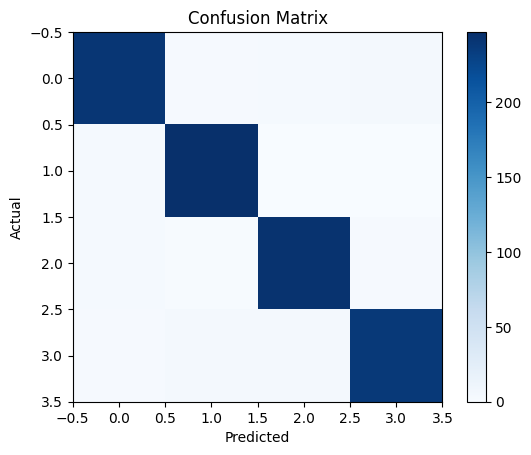

Model saved.


In [26]:
if __name__ == '__main__':
    main()

In [16]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")

model = build_model(input_shape=(320, 320, 3), num_classes=4)
model.load_weights("EyeNet_Model.h5")

In [17]:
model_path = "EyeNet_Model.h5"
test_dir = r"C:\Users\User\Desktop\dataset_split\test"

datagen = ImageDataGenerator(rescale=1.0 / 255)
test_gen = datagen.flow_from_directory(
    test_dir,
    target_size=(320, 320),
    batch_size=16,
    class_mode='categorical',
    shuffle=False
)

# Get true & predicted labels
y_true = []
y_pred = []

for batch_x, batch_y in test_gen:
    preds = model.predict(batch_x)
    y_true.extend(np.argmax(batch_y, axis=1))
    y_pred.extend(np.argmax(preds, axis=1))
    if len(y_true) >= 1000:  # stop after full test set
        break

y_true = np.array(y_true[:1000])
y_pred = np.array(y_pred[:1000])

# Confusion matrix & report
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

report = classification_report(
    y_true, y_pred,
    target_names=["Cataract", "Conjunctivitis", "Normal", "Stye"]
)
print(report)

Found 1000 images belonging to 4 classes.
1/1 [==============================] - 0s 64ms/step
Confusion Matrix:
[[241   2   3   4]
 [  3 247   0   0]
 [  3   1 244   2]
 [  2   5   5 238]]
                precision    recall  f1-score   support

      Cataract       0.97      0.96      0.97       250
Conjunctivitis       0.97      0.99      0.98       250
        Normal       0.97      0.98      0.97       250
          Stye       0.98      0.95      0.96       250

      accuracy                           0.97      1000
     macro avg       0.97      0.97      0.97      1000
  weighted avg       0.97      0.97      0.97      1000



In [18]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Assume you already have:
y_true = test_gen.classes
y_pred = np.argmax(model.predict(test_gen), axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

n_classes = cm.shape[0]

for i in range(n_classes):
    TP = cm[i, i]
    FP = cm[:, i].sum() - TP
    FN = cm[i, :].sum() - TP
    TN = cm.sum() - (TP + FP + FN)
    print(f"\nClass {i}:")
    print(f"  TP: {TP}")
    print(f"  FP: {FP}")
    print(f"  FN: {FN}")
    print(f"  TN: {TN}")

63/63 [==============================] - 3s 33ms/step
Confusion Matrix:
 [[241   2   3   4]
 [  3 247   0   0]
 [  3   1 244   2]
 [  2   5   5 238]]

Class 0:
  TP: 241
  FP: 8
  FN: 9
  TN: 742

Class 1:
  TP: 247
  FP: 8
  FN: 3
  TN: 742

Class 2:
  TP: 244
  FP: 8
  FN: 6
  TN: 742

Class 3:
  TP: 238
  FP: 6
  FN: 12
  TN: 744
